In [1]:
!pip install tensorflow --quiet

In [2]:
import os, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')
pd.set_option('display.max_colwidth', None)
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Import Dataset

In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## Preprocess the Dataset

Here, we are going to use the same set of pre-processing steps we used in [the previous notebook](). You can find a detailed explanation of the steps in the link. 

In [5]:
duplicates = train[train.duplicated('text')]
problematic_duplicates = []

for i in range(duplicates.text.nunique()):
    duplicate_subset = train[train.text == duplicates.text.unique()[i]]
    if len(duplicate_subset) > 1 and duplicate_subset.target.nunique() == 2:
        problematic_duplicates.append(i)
        
print(problematic_duplicates)

[4, 7, 12, 15, 24, 26, 33, 34, 35, 36, 38, 39, 42, 44, 46, 51, 55, 58]


In [6]:
target_list = [0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0]

for problematic_index in range(len(problematic_duplicates)): 
    train.target = np.where(train.text == duplicates.text.unique()[problematic_index], 
                            target_list[problematic_index], train.target)

In [7]:
def clean_text(dataframe):
    dataframe.text = dataframe.text.apply(lambda x: str.lower(x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'http\S+', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'#', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'@', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\n', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\d+', '', x))
    return(dataframe)

In [8]:
clean_train = clean_text(train)
clean_train_balanced = clean_train.groupby('target').sample(3000, random_state = 1048596)

In [9]:
train_df, val_df = np.split(clean_train_balanced.sample(frac = 1), [int(0.8 * len(clean_train_balanced))])

## Define and Train Model - Fourth Model

In this model, we are going to represent each tweet as a vector. We are going to do this using the tokenizer module in the tensorflow package. This module will turn each text into a sequence of integers where the integer corresponds to a token inside a dictionary. In this case, we are going to set the size of our dictionary to 3,000, meaning that we would only map the 3,000 most frequently occurring words inside our dataset. 

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
VOCAB_SIZE = 3000
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_df.text)
word_index = tokenizer.word_index

Now, we need to convert the texts into vector sequences using the tokenizer and pad the sequences so that the vector sequences are of equal length. Before we do, let's first determine the maximum length of the texts so that we don't lose any information when we pad the sequences. We are going to determine the maximum length of the vector sequences and set it as our padding length. 

In [12]:
padding_length = np.max([len(x) for x in train_df.text])

In [13]:
train_sequences = tokenizer.texts_to_sequences(train_df.text)
train_padded = pad_sequences(train_sequences,
                             maxlen= padding_length,
                             padding= 'post',
                             truncating= 'post')

val_sequences = tokenizer.texts_to_sequences(val_df.text)
val_padded = pad_sequences(val_sequences,
                           maxlen= padding_length,
                           padding= 'post',
                           truncating= 'post')

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'model/best_performed_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In our fourth model, we are going to use an embedding layer whose dimension of the dense embedding (the ouput) is going to be 128, a bidirectional LSTM layer whose output dimension is 64 (half the dimension of the previous layer), a dense layer of 32 dimensions, a dropout layer, and finally another dense layer with the sigmoid activation function.

In [15]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, 128, input_length = padding_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [16]:
history = model.fit(train_padded,
                    train_df.target,
                    validation_data = (val_padded, val_df.target),
                    epochs = 30,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5540
Epoch 1: val_loss improved from inf to 0.68275, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 22s 99ms/step - loss: 0.6903 - accuracy: 0.5540 - val_loss: 0.6827 - val_accuracy: 0.6958
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.6990
Epoch 2: val_loss improved from 0.68275 to 0.56697, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 5s 34ms/step - loss: 0.6393 - accuracy: 0.6990 - val_loss: 0.5670 - val_accuracy: 0.7342
Epoch 3/30
149/150 [============================>.] - ETA: 0s - loss: 0.5092 - accuracy: 0.7712
Epoch 3: val_loss improved from 0.56697 to 0.48161, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 4s 28ms/step - loss: 0.5084 - accuracy: 0.7721 - val_loss: 0.4816 - val_accuracy: 0.7975
Epoch 4/30
147/150 

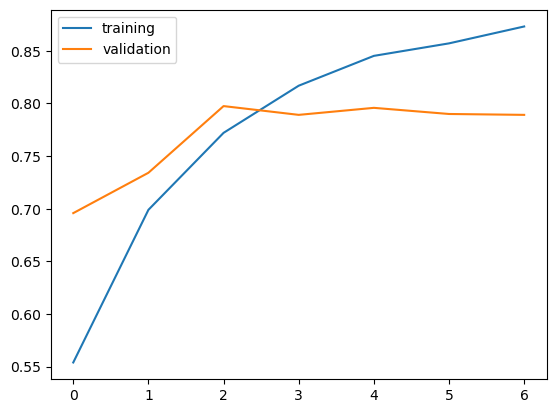

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

The plot suggested that the model started to over-fit around the third epoch. The fourth model returned a validation accuracy of .77, which was not significantly better than our previous models. 

## Define and Train Model - Fifth Model

In our next model, we are going to use two bidirectional LSTM layers. To do so, we are going to set **return_sequences** to True so that the output of the first bidirectional LSTM layer can be fed onto the next. These two layers are going to be followed by a dropout layer and two dense layers each of 32 and 1 dimension(s). 

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, 128, input_length = padding_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [19]:
history = model.fit(train_padded,
                    train_df.target,
                    validation_data = (val_padded, val_df.target),
                    epochs = 30,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5440
Epoch 1: val_loss did not improve from 0.44500
150/150 [==============================] - 20s 87ms/step - loss: 0.6903 - accuracy: 0.5440 - val_loss: 0.6812 - val_accuracy: 0.6692
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.6979
Epoch 2: val_loss did not improve from 0.44500
150/150 [==============================] - 7s 49ms/step - loss: 0.6095 - accuracy: 0.6979 - val_loss: 0.4768 - val_accuracy: 0.7792
Epoch 3/30
149/150 [============================>.] - ETA: 0s - loss: 0.4363 - accuracy: 0.8058
Epoch 3: val_loss improved from 0.44500 to 0.44224, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 6s 43ms/step - loss: 0.4352 - accuracy: 0.8067 - val_loss: 0.4422 - val_accuracy: 0.7942
Epoch 4/30
149/150 [============================>.] - ETA: 0s - loss: 0.3570 - accuracy: 0.8561
Epoch 4: val_loss did not

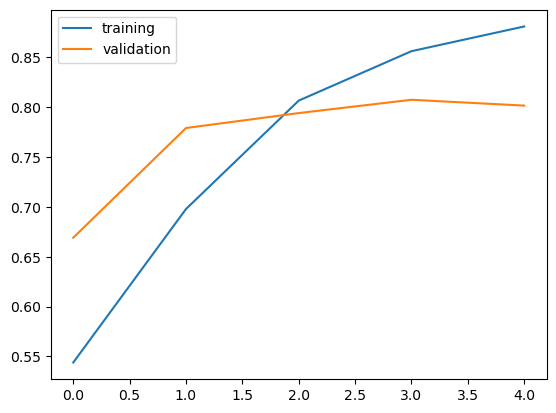

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

The plot suggested that the model started to over-fit around the third epoch. The fifth model returned a validation accuracy of .77, which was not significantly better than our previous models. We are going to revisit our third model that performed the best so far and see if we can improve on its performance. 